# Metalens Studies Automation
written by: Taylor Contreras, Feb 5 2021

This code controls the automation of the oscilliscope and the motors to take measurements of the light intensity of a SiPM. An LED is aligned with a diffraction grating in front of the SiPM. The SiPM and LED are on tracks that can move vertically. This allows the calibration of the SiPM with no light and for the measurement of light intensity as a function of angle from the diffraction grating. 

See other notebooks for more details and tests (PyVisa_tutorial.ipynb, Ardruino_testing.ipynb, Motot_control_testing.ipynb)

In [1]:
from motor import Motor
import oscilloscope as osc
from metalens_experiment import Experiment
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import csv
import pyvisa
import pyfirmata
import numpy as np
import time

## Save Data Function

In [5]:
file_name = 'run03_metalens_100ns_10sweeps.csv'
def SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, rot_angle):
    with open('data/'+file_name, mode='w') as file:
                writer = csv.writer(file)
                
                writer.writerow(['position_lens'])
                writer.writerow([position_lens]) 
                writer.writerow(['position_led'])
                writer.writerow([position_led])
                writer.writerow(['positions_sipm'])
                writer.writerow(positions_sipm)
                writer.writerow(['maxes'])
                writer.writerow(maxes)
                writer.writerow(['rotation'])
                writer.writerow([rot_angle])

### Connect to the oscilliscope

In [6]:
# Before running, connect the laptop to the oscilloscope through the USBTMC
rm = pyvisa.ResourceManager()
# Use the name this prints to grab the instrument in the next step
rm.list_resources() 

('USB0::0x05FF::0x1023::4206N21552::INSTR',
 'ASRL3::INSTR',
 'ASRL10::INSTR',
 'ASRL12::INSTR')

In [7]:
# Grabs the instrument and prints name
scope = rm.open_resource('USB0::0x05FF::0x1023::4206N21552::INSTR')

### Connect to the Arduino

In [2]:
# Use Arduino IDE to find the port name
# under Tools->Port
# This time is was COM3
board1 = pyfirmata.Arduino('COM3')
#board2 = pyfirmata.Arduino('COM6')

# must set iterator in order to take input (the button)
# make sure to run only once
it1 = pyfirmata.util.Iterator(board1)
it1.start()
#it2 = pyfirmata.util.Iterator(board2)
#it2.start()

### Make 'exp' to hold all the experiment objects and variables

In [8]:
# Creat sipm and led motor class objects
sipm_step_pin = 8
sipm_dir_pin = 9
sipm_button_pin = 6
led_step_pin = 10
led_dir_pin = 11
led_button_pin = 5
rot_step_pin = 10
rot_dir_pin = 11
lens_step_pin = 12
lens_dir_pin = 13
lens_button_pin = 5
board1.digital[sipm_button_pin].mode = pyfirmata.INPUT
board1.digital[lens_button_pin].mode = pyfirmata.INPUT
sipm_motor = Motor(board1, sipm_step_pin, sipm_dir_pin, 'sipm', sipm_button_pin) # pos dir is toward motor
led_motor = Motor(board1, led_step_pin, led_dir_pin, 'led') # pos dir is up
rot_motor = Motor(board1, rot_step_pin, rot_dir_pin, 'rot')
lens_motor = Motor(board1, lens_step_pin, lens_dir_pin, 'lens', lens_button_pin) # pos dir is toward motor

#sipm_motor.CreatePositionFile()
#led_motor.CreatePositionFile()

In [9]:
exp = Experiment(rot_motor, lens_motor, led_motor, sipm_motor, scope, align_with_file=True)

In [10]:
exp.PrintInfo()

---Experiment---
Motor name: lens
    Step pin: 12
    Dir pin: 13
    Button pin: 5
Motor name: sipm
    Step pin: 8
    Dir pin: 9
    Button pin: 6
Motor name: rot
    Step pin: 10
    Dir pin: 11
    Button pin: 0
LED motor off
--Alignments--
    sipm_center = 65.27
    led_center = 268.02289179238477
    lens_center = 323.515
    lens_diam = 9.8
    mount_center = 177.0
    mount_left_outer_edge = 311.71500000000003
    mount_left_inner_edge = 317.71500000000003
    mount_diam = 10.6
    rot_center = 19851
Oscilloscope: *IDN LECROY,WAVERUNNER8054,LCRY4206N21552,8.5.1

    Number of Sweeps: 15


#### Tests and examples of movements and measurements

In [8]:
exp.Align()

LED motor is off. Switch motors to align


In [26]:
osc.MeasurePeaktoPeak(scope, 10)

0.0281551661028061

In [1381]:
exp.SwitchMotor('rot')

Manually connect rot motor and disconnect led motor


In [1387]:
exp.RotateLens(180)

In [189]:
exp.sipm_motor.MoveMotor(10)

SerialException: WriteFile failed (PermissionError(13, 'The device does not recognize the command.', None, 22))

In [175]:
for i in range(50):
    exp.sipm_motor.MoveMotor(-0.2)
    time.sleep(0.25)

In [155]:
exp.lens_motor.MoveMotor(-5)

In [167]:
exp.lens_motor.MoveMotor(-5)

In [233]:
exp.SwitchMotor('rot')

Manually connect rot motor and disconnect led motor


# Alignment

If you have replaced any pieces inside the dark box, you must first by eye align the sipm, led, and lens centers. Then run the following alignments for the new experimental setup. The alignments take approximately 15 minutes.

### Alignment of SiPM and LED

'80/80'

Old SiPM center = 65.21000000000001
New SiPM center = 65.29


Text(0, 0.5, 'Peak to Peak voltage [V]')

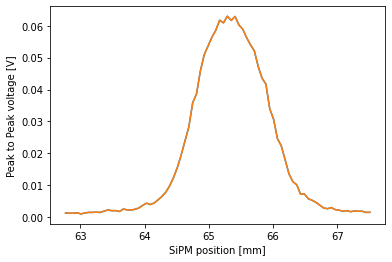

In [2666]:
width=5. 
num_measurements=80
position_led, positions_sipm, maxes = exp.FindSiPMCenter(width, num_measurements)
plt.plot(positions_sipm, maxes)
plt.xlabel('SiPM position [mm]')
plt.ylabel('Peak to Peak voltage [V]')

In [2667]:
exp.Align('sipm')

### Align the Lens to the LED

Text(0, 0.5, 'Peak to Peak voltage [V]')

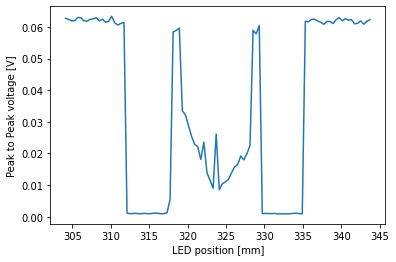

In [2550]:
width=40.
num_measurements=100
positions_lens, maxes = exp.ScanLens(width, num_measurements)
plt.plot(positions_lens, maxes)
plt.xlabel('LED position [mm]')
plt.ylabel('Peak to Peak voltage [V]')

Mount edges 311.73 317.73
Mount edges 318.93 328.13
Mount edges 329.33 334.93


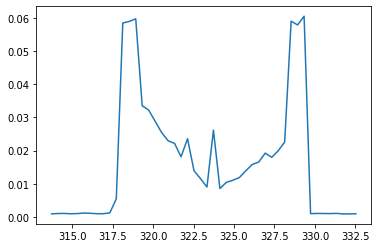

In [2551]:
peak_width=4
prominence=0.02
lens_data = exp.FindLensData(positions_lens, maxes, peak_width, prominence)
plt.plot(lens_data[0], lens_data[1])

In [298]:
exp.lens_motor.MoveMotor(276 - exp.lens_motor.GetCurrentPosition())

In [1392]:
from scipy import signal

In [1489]:
from scipy import signal
peaks, _ = signal.find_peaks(lens_data[1], prominence=.01)
widths = signal.peak_widths(lens_data[1], peaks)

exp.alignments['lens_center'] = (lens_data[0][int(widths[3])] + lens_data[0][int(widths[2])])/2.

TypeError: only size-1 arrays can be converted to Python scalars

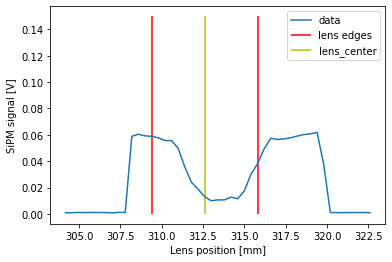

In [1493]:
exp.FindLensCenter(lens_data, glass_prominence=0.001)

In [1412]:
exp.Align('sipm')
exp.Align('lens')

#### Only run if the data is too noisy

In [633]:
from scipy import signal
b, a = signal.ellip(2, 0.1, 120, 0.125)  # Filter to be applied.
fgust = signal.filtfilt(b, a, lens_data[1], method="gust")
fpad = signal.filtfilt(b, a, lens_data[1], padlen=50)
plt.plot(lens_data[1], 'k-', label='input')
plt.plot(fgust, 'b-', linewidth=4, label='gust')
plt.plot(fpad, 'c-', linewidth=1.5, label='pad')
plt.legend(loc='best')
plt.show()

smoothed_maxes = fgust

ValueError: The length of the input vector x must be greater than padlen, which is 50.

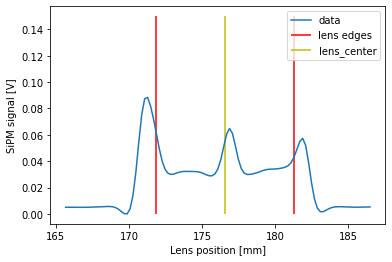

In [46]:
smoothed_lens_data = [lens_data[0], smoothed_maxes]
exp.FindLensCenter(smoothed_lens_data)

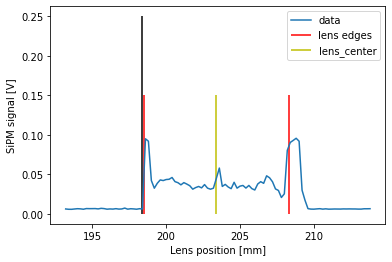

In [77]:
plt.plot(lens_data[0], lens_data[1], label='data')
plt.vlines(exp.alignments['lens_center'] - exp.alignments['lens_diam']/2., 0,.15, color='r', label='lens edges')
plt.vlines(exp.alignments['lens_center'] + exp.alignments['lens_diam']/2., 0, .15, color='r')
plt.vlines(exp.alignments['lens_center'], 0, .15, color='y', label='lens_center')
plt.vlines(exp.alignments['mount_left_inner_edge'], 0., .25, color='k')
plt.xlabel('Lens position [mm]')
plt.ylabel('SiPM signal [V]')
plt.legend()
plt.show()

In [117]:
exp.Align()

LED motor is off. Switch motors to align


### Align the lens do be perpindicular with the beam
You must make sure the rotation motor is connected and  not the LED motor.

In [1470]:
exp.SwitchMotor('rot')

Manually connect rot motor and disconnect led motor


In [2552]:
exp.Align('sipm')


In [2572]:
width = 10.
num_measurements = 50
exp.lens_motor.MoveMotor(exp.alignments['mount_left_outer_edge'] - exp.lens_motor.GetCurrentPosition())
positions_lens, maxes = exp.ScanLens(width, num_measurements)

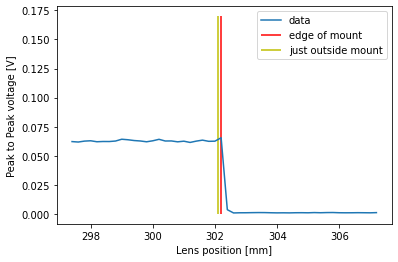

In [1497]:
buffer = .1
plt.plot(positions_lens, maxes, label='data')
plt.vlines(exp.alignments['mount_left_outer_edge'], 0, .17, 'r', label='edge of mount')
plt.vlines(exp.alignments['mount_left_outer_edge']-buffer, 0, .17, 'y', label='just outside mount')
plt.xlabel('Lens position [mm]')
plt.ylabel('Peak to Peak voltage [V]')
plt.legend()
plt.show()

'Rot step: 100/100'

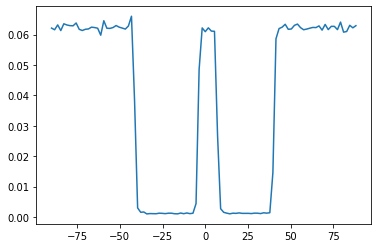

In [2582]:
exp.lens_motor.MoveMotor(exp.alignments['mount_left_outer_edge'] - buffer - exp.lens_motor.GetCurrentPosition())
rot_data = exp.ScanRotation(180,100)
plt.plot((rot_data[:,0] - rot_data[len(rot_data[:,0])//2,0])*(1.8/8.), rot_data[:,1])
#exp.lens_motor.MoveMotor(-(exp.alignments['mount_left_outer_edge'] - buffer - exp.lens_motor.GetCurrentPosition()))

Rotated 0.0 to align


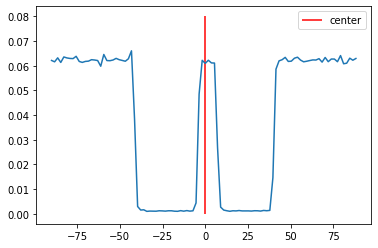

19851
Rotated 0.0 to align


In [2583]:
old_center = exp.alignments['rot_center']
exp.FindLensRotationAlignment(rot_data, prominence=0.02)
print(exp.alignments['rot_center'])
exp.WriteAlignment()
print('Rotated '+str((old_center - exp.alignments['rot_center'])*(1.8/8.))+' to align')

In [738]:
current_step = self.rot_motor.GetCurrentNumSteps()
            self.rot_motor.MoveSteps(center_step - self.rot_motor.GetCurrentNumSteps())
            self.alignments['rot_center'] = center_step
            print('Rotated '+str((current_step - center_step)*(1.8/8.))+' to align')

IndentationError: unexpected indent (<ipython-input-738-20ae84bcd935>, line 2)

In [2584]:
exp.alignments['rot_center']

19851

In [2585]:
exp.rot_motor.GetCurrentNumSteps()

19851

In [2586]:
old_center = exp.alignments['rot_center']
exp.rot_motor.MoveMotor(old_center-exp.rot_motor.GetCurrentNumSteps())

In [2587]:
exp.Align('rot')

In [1476]:
exp.RotateLens(10)

In [105]:
exp.lens_motor.MoveMotor(-10)

### Align LED in vertical direction to lens

#### ----- Warning -----
You must make sure the LED motor is connected, rather than the rotation motor.

In [145]:
exp.SwitchMotor('led')

Manually connect led motor and disconnect rot motor


In [147]:
exp.Align()

Rotation motor is off. Switch motors to align


In [106]:
width = 10.
num_measurements = 30
buffer = 0.0
exp.lens_motor.MoveMotor(exp.alignments['mount_left_inner_edge'] - exp.lens_motor.GetCurrentPosition() + buffer)
#exp.Align()
#exp.lens_motor.MoveMotor(-5)
positions_lens, maxes = exp.ScanLens(width, num_measurements)
#exp.lens_motor.MoveMotor(5)

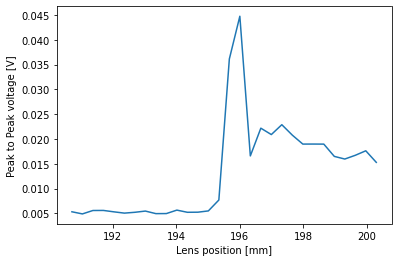

In [107]:
plt.plot(positions_lens, maxes, label='data')
plt.xlabel('Lens position [mm]')
plt.ylabel('Peak to Peak voltage [V]')
plt.show()

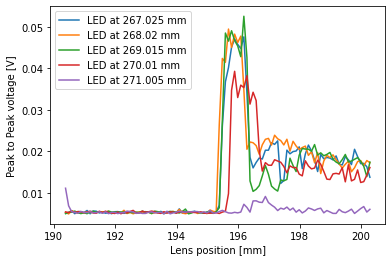

In [113]:
led_scan_width = 5.
lens_scan_width = 10.
num_measurements_led = 5
num_measurements_lens = 100
led_data = exp.ScanLED(led_scan_width, lens_scan_width, num_measurements_led, num_measurements_lens)

for led_step in led_data:
    plt.plot(led_step[0], led_step[1], label='LED at '+str(led_step[2])+' mm')
plt.xlabel('Lens position [mm]')
plt.legend()
plt.xlabel('Lens position [mm]')
plt.ylabel('Peak to Peak voltage [V]')
plt.show()

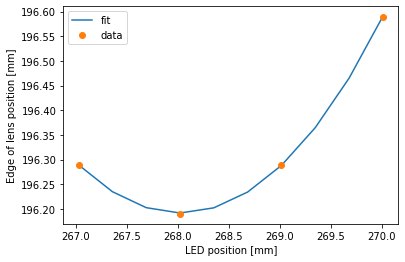

LED Center = 268.02289179238477


In [114]:
exp.FindLEDCenter(led_data, prominence=0.02, guess=[5., 268., 198.])

In [125]:
exp.Align()

LED motor is off. Switch motors to align


In [80]:
exp.RotateLens(10)

#### Use this code if the data is particulalry noisy and you are having trouble finding peaks

In [187]:
from scipy import signal
b, a = signal.ellip(6, 0.01, 120, 0.125)  # Filter to be applied.
fgust = signal.filtfilt(b, a, maxes, method="gust")
fpad = signal.filtfilt(b, a, maxes, padlen=50)
plt.plot(maxes, 'k-', label='input')
plt.plot(fgust, 'b-', linewidth=4, label='gust')
plt.plot(fpad, 'c-', linewidth=1.5, label='pad')
plt.legend(loc='best')
plt.show()

smoothed_maxes = fgust

ValueError: The length of the input vector x must be greater than padlen, which is 50.

In [188]:
np.shape(maxes)

(30,)

# Runs

In [78]:
exp.SwitchMotor('rot')

Manually connect rot motor and disconnect led motor


'50/50'

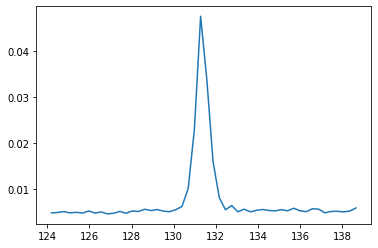

In [118]:
exp.Align()
position_led, positions_sipm, maxes = exp.ScanMaxes(width=15., num_measurements=50)
plt.plot(positions_sipm, maxes)

'100/100'

Total run time = 2.434846905867259


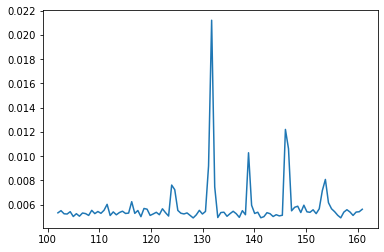

In [122]:
start_time = time.time()
exp.Align()
exp.lens_motor.MoveMotor(3)
position_led, positions_sipm, maxes = exp.ScanMaxes(width=60., num_measurements=100)
plt.plot(positions_sipm, maxes)
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

'100/100'

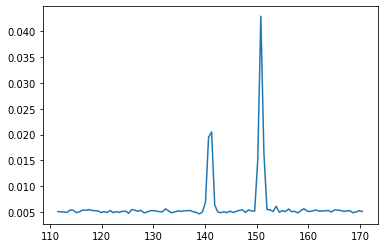

In [189]:
exp.Align()
exp.RotateLens(180.)
exp.lens_motor.MoveMotor(4)
position_led, positions_sipm, maxes = exp.ScanMaxes(width=60., num_measurements=100)
plt.plot(positions_sipm, maxes)

# Take dark noise data

'200/200'

NameError: name 'SaveScanMaxesData' is not defined

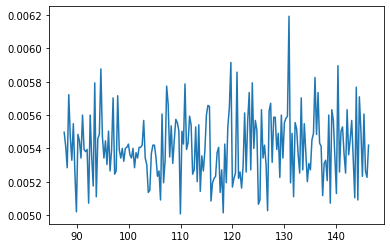

In [119]:
# Take data with led spot on the substrate
run_num = 576
sipm_scan_width = 60
sipm_num_measurements = 200
rot_angle = 0.0
base_file_name = '_darknoise_100ns_15sweeps.csv'
file_name = 'run'+str(run_num)+base_file_name

position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements)
plt.plot(positions_sipm, maxes)
position_lens = exp.lens_motor.GetCurrentPosition()

SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, rot_angle)

## Take air reference data

'200/200'

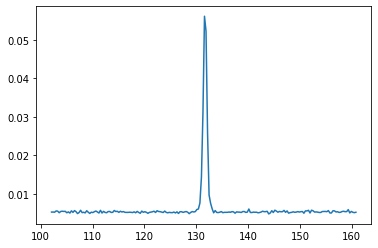

In [137]:
# Take data with led spot on the substrate
run_num = 1418
sipm_scan_width = 60
sipm_num_measurements = 200
rot_angle = 0.0
#base_file_name = '_metalens_100ns_15sweeps.csv'
file_name = 'run'+str(run_num)+base_file_name

exp.Align()
exp.lens_motor.MoveMotor(-40)
position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements)
exp.lens_motor.MoveMotor(40)
plt.plot(positions_sipm, maxes)
position_lens = exp.lens_motor.GetCurrentPosition()

SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, rot_angle)

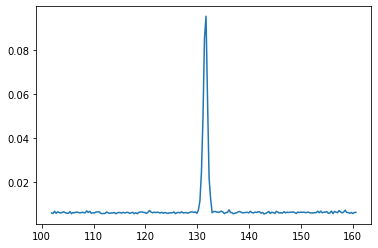

In [78]:
plt.plot(positions_sipm, maxes)
#plt.xlim(115,120)
plt.show()

'200/200'

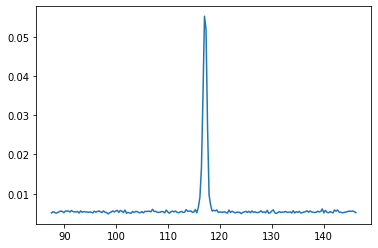

In [75]:
# Take data with led spot on the substrate
#run_num = 575
sipm_scan_width = 60
sipm_num_measurements = 200
rot_angle = 0.0
#base_file_name = '_metalens_100ns_15sweeps.csv'
#file_name = 'run'+str(run_num)+base_file_name

exp.Align()
exp.lens_motor.MoveMotor(-40)
position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements)
exp.lens_motor.MoveMotor(40)
plt.plot(positions_sipm, maxes)
position_lens = exp.lens_motor.GetCurrentPosition()

#SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, rot_angle)

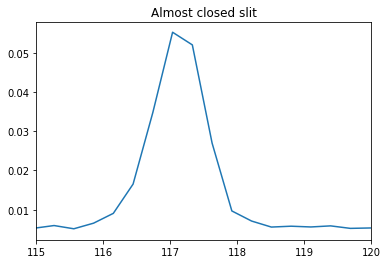

In [77]:
plt.plot(positions_sipm, maxes)
plt.title('Almost closed slit')
plt.xlim(115,120)
plt.show()

## Take substrate reference data

In [139]:
# For a scan with just substrate, align the center of lens based on mount edges
from scipy import signal
peaks, _ = signal.find_peaks(lens_data[1], prominence=.1)
widths = signal.peak_widths(lens_data[1], peaks)

exp.alignments['lens_center'] = (lens_data[0][int(widths[3])] + lens_data[0][int(widths[2])])/2.

In [174]:
# Run as of 5/26/2022
start_time = time.time()
num_rots = 4
drot = 20
lens_scan_width = 6.
lens_num_measurements = 3 #120
lens_dx = lens_scan_width / max((lens_num_measurements-1),1)
sipm_scan_width = 8
sipm_num_measurements = 40
base_file_name = '_substrate_100ns_15sweeps.csv'
run_num = 1419

exp.Align()
current_rot = -drot*num_rots/2
exp.RotateLens(current_rot)
for rot in range(num_rots+1):
    
    exp.Align('lens')
    exp.lens_motor.MoveMotor(-lens_scan_width/2.)
    for lens_scan in range(lens_num_measurements):
    
        exp.Align('sipm')
        position_lens = exp.lens_motor.GetCurrentPosition()
        position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=False)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, current_rot)
        exp.lens_motor.MoveMotor(lens_dx)
        run_num += 1
        #print(rot, lens_scan, current_rot, lens_dx)

    exp.RotateLens(drot)  
    current_rot += drot

exp.Align('rot')
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

LED motor is off. Switch motors to align
Total run time = 13.07053189277649


In [194]:
exp.lens_motor.MoveMotor(-7)

In [52]:
from scipy import signal


## Rotation and symmetry runs

In [94]:
# Running over many lens positions to check lens symmetry
start_time = time.time()
lens_scan_width = 5. # mm (lens radius)
num_scans = 5
sipm_scan_width = 60
sipm_num_measurements = 200
base_file_name = '_metalens_100ns_15sweeps.csv'
run_num = 500
dx_lens = lens_scan_width / num_scans
lens_pos = 0.0
rot_width = 30.
rot_scans = 3
drot = rot_width/rot_scans
exp.Align()
for rot in range(rot_scans):

    for i in range(num_scans):
        clear_output(wait=True)
        display('Scan: '+str(i+1)+"/"+str(num_scans)+', rot: '+str(rot+1)+'/'+str(rot_scans))
        
        exp.Align('lens')
        exp.Align('sipm')
        exp.lens_motor.MoveMotor(dx_lens*i)
        position_lens = exp.lens_motor.GetCurrentPosition()
        position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=False)
        file_name = 'run'+str(run_num)+base_file_name
        rot_angle = rot * drot
        SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, rot_angle)
        run_num += 1

        exp.Align('lens')
        exp.Align('sipm')
        exp.lens_motor.MoveMotor(-dx_lens*i)
        position_lens = exp.lens_motor.GetCurrentPosition()
        position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=False)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, rot_angle)
        run_num += 1

    exp.RotateLens(drot)
    
end_time = time.time()
exp.RotateLens(-rot_width)

'Scan: 5/5, rot: 3/3'

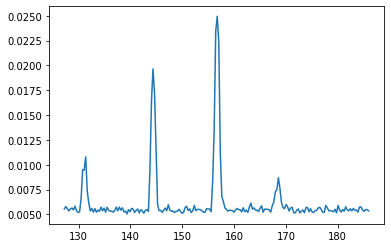

In [323]:
plt.plot(positions_sipm, maxes)

# Runs for Adam
Very fine grained runs over entire metalens

In [127]:
# Running over many lens positions to check lens symmetry
start_time = time.time()
lens_scan_width = 2. # mm (lens radius)
num_scans = 20
sipm_scan_width = 120
sipm_num_measurements = 600
base_file_name = '_metalens_100ns_15sweeps.csv'
run_num = 531
dx_lens = lens_scan_width / num_scans

exp.Align()
exp.lens_motor.MoveMotor(-lens_scan_width/2.)
for i in range(num_scans):
    clear_output(wait=True)
    display('Scan: '+str(i+1)+"/"+str(num_scans))

    exp.Align('sipm')
    position_lens = exp.lens_motor.GetCurrentPosition()
    position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=False)
    file_name = 'run'+str(run_num)+base_file_name
    SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, 0.0)
    #print(position_lens)
    #plt.plot(positions_sipm, maxes, label=position_lens)
    #plt.legend()
    #plt.show()
    exp.lens_motor.MoveMotor(dx_lens)
    run_num += 1
    
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

'Scan: 20/20'

Total run time = 353.4198785742124


In [128]:
# Running over many lens positions to check lens symmetry
start_time = time.time()
lens_scan_width = 24. # mm (lens radius)
num_scans = 24
sipm_scan_width = 120
sipm_num_measurements = 600
base_file_name = '_metalens_100ns_15sweeps.csv'
#run_num = 531
dx_lens = lens_scan_width / num_scans

exp.Align()
exp.lens_motor.MoveMotor(-lens_scan_width/2.)
for i in range(num_scans):
    clear_output(wait=True)
    display('Scan: '+str(i+1)+"/"+str(num_scans))

    exp.Align('sipm')
    position_lens = exp.lens_motor.GetCurrentPosition()
    position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=False)
    file_name = 'run'+str(run_num)+base_file_name
    SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, 0.0)
    #print(position_lens)
    #plt.plot(positions_sipm, maxes, label=position_lens)
    #plt.legend()
    #plt.show()
    exp.lens_motor.MoveMotor(dx_lens)
    run_num += 1
    
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

'Scan: 24/24'

Total run time = 425.63242812951404


In [21]:
# Special run to get fine grained data at center, at lens edge, and at mount edge
start_time = time.time()
num_rots = 2
max_rot = 20.
drot = max_rot / (num_rots-1)
lens_scan_width = 3. # mm (lens radius)
num_lens_scans = 30
dx_lens = lens_scan_width / num_lens_scans
sipm_scan_width = 120
sipm_num_measurements = 600
sipm_scan_width_less = 60
sipm_num_measurements_less = 300
base_file_name = '_metalens_100ns_15sweeps.csv'
run_num = 576

exp.Align()
for rot in range(num_rots):
    current_rot = drot*rot
    
    exp.Align('lens')
    exp.lens_motor.MoveMotor(-lens_scan_width/2.)
    for i in range(num_lens_scans):
        exp.Align('sipm')
        position_lens = exp.lens_motor.GetCurrentPosition()
        position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width_less, num_measurements=sipm_num_measurements_less, print_progress=False)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, current_rot)
        run_num += 1
        exp.lens_motor.MoveMotor(dx_lens)  

    # Take edge of lens data
    exp.lens_motor.MoveMotor(exp.alignments['mount_left_inner_edge'] - exp.lens_motor.GetCurrentPosition())
    exp.lens_motor.MoveMotor(-lens_scan_width/2.)
    for i in range(num_lens_scans):
        position_lens = exp.lens_motor.GetCurrentPosition()
        position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width_less, num_measurements=sipm_num_measurements_less, print_progress=False)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, current_rot)
        run_num += 1
        exp.lens_motor.MoveMotor(dx_lens)

    # Take edge of mount data
    exp.lens_motor.MoveMotor(-lens_scan_width/2.)
    exp.lens_motor.MoveMotor(exp.alignments['mount_left_outer_edge'] - exp.lens_motor.GetCurrentPosition())
    for i in range(num_lens_scans):
        position_lens = exp.lens_motor.GetCurrentPosition()
        position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width_less, num_measurements=sipm_num_measurements_less, print_progress=False)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, current_rot)
        run_num += 1
        exp.lens_motor.MoveMotor(dx_lens)
    
    exp.RotateLens(drot)  

exp.RotateLens(-drot*num_rots)
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

LED motor is off. Switch motors to align
Total run time = 1157.215026072661


In [47]:
center

203.815

In [75]:
exp.lens_motor.MoveMotor(center - exp.lens_motor.GetCurrentPosition())

In [52]:
exp.lens_motor.GetCurrentPosition()

203.815

In [312]:
exp.Align('rot')

In [143]:
# Run as of 5/4/2022
start_time = time.time()
num_rots = 2
drot = 20
lens_scan_width = 12.
lens_num_measurements = 3 #120
lens_dx = lens_scan_width / lens_num_measurements
sipm_scan_width = 60
sipm_num_measurements = 120
base_file_name = '_substrate_100ns_15sweeps.csv'
run_num = 1058

exp.Align()
current_rot = -drot*num_rots/2
exp.RotateLens(current_rot)
for rot in range(num_rots+1):
    
    exp.Align('lens')
    exp.lens_motor.MoveMotor(-lens_scan_width/2.)
    for lens_scan in range(lens_num_measurements):
    
        exp.Align('sipm')
        position_lens = exp.lens_motor.GetCurrentPosition()
        position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=False)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, current_rot)
        exp.lens_motor.MoveMotor(lens_dx)
        run_num += 1
        #print(rot, lens_scan, current_rot)

    exp.RotateLens(drot)  
    current_rot += drot

exp.Align('rot')
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

LED motor is off. Switch motors to align
0 0 -20.0
0 1 -20.0
0 2 -20.0
1 0 0.0
1 1 0.0
1 2 0.0
2 0 20.0
2 1 20.0
2 2 20.0
Total run time = 1.2271172324816386


## Strip Metalenses

In [1851]:
exp.SwitchMotor('led')


Manually connect led motor and disconnect rot motor


In [2578]:
exp.Align('rot')

#### Scanning the LED up and down to find lens center in vertical position

'Scan: 15/15'

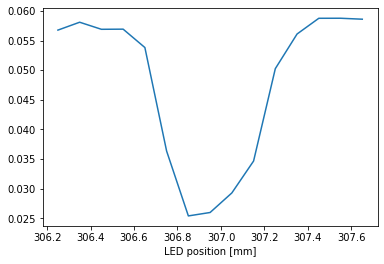

In [2380]:
led_scan_width = 1.5
exp.Align('sipm')

dx_led = 0.1
num_led_steps = int(led_scan_width / dx_led)
maxes = []
led_positions = []

exp.led_motor.MoveMotor(-led_scan_width/2.)
for step in range(num_led_steps):
    clear_output(wait=True)
    display('Scan: '+str(step+1)+"/"+str(num_led_steps))
    maxes.append(osc.MeasurePeaktoPeak(scope, 15))
    led_positions.append(exp.led_motor.GetCurrentPosition())
    exp.led_motor.MoveMotor(dx_led)
exp.led_motor.MoveMotor(-led_scan_width/2.)
plt.plot(led_positions, np.array(maxes))
plt.xlabel('LED position [mm]')
plt.show()

In [2282]:
peaks, _ = signal.find_peaks(np.array(maxes)*-1, prominence=.01)
widths = signal.peak_widths(np.array(maxes)*-1, peaks)
lens_center = (led_positions[int(widths[2])] + led_positions[int(widths[3])])/2.
print(lens_center)

306.475


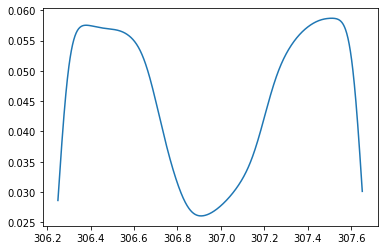

306.95770770770775


In [2381]:
meio = (led_positions[len(led_positions)-1]+led_positions[0])/2
x = np.linspace(led_positions[0], led_positions[len(led_positions)-1], 1000)
FWHM = 0.1
sigma=FWHM/2.3548
G = np.exp(-(x-meio)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))
G = G/sum(G)

interp = interpolate.interp1d(led_positions, maxes, kind = "linear")
maxes3 = interp(x)
maxes3 = np.convolve(maxes3, G, mode='same')

plt.plot(x,maxes3)
plt.show()

peaks, _ = signal.find_peaks(np.array(maxes3)*-1, prominence=.01)
widths = signal.peak_widths(np.array(maxes3)*-1, peaks)
lens_center = (x[int(widths[2])] + x[int(widths[3])])/2.
print(lens_center)

In [2388]:
exp.led_motor.MoveMotor(lens_center - exp.led_motor.GetCurrentPosition())

In [2601]:
exp.Align('rot')

#### Scanning across lens  to find center of lens horizontally

In [2675]:
def StripFindCenter(lens_scan_width,dx_lens,rot):
    exp.Align('sipm')


    num_lens_steps = int(lens_scan_width / dx_lens)
    maxes = []
    lens_positions = []
    exp.lens_motor.MoveMotor(-lens_scan_width/2.)
    if rot>0:
        exp.Align('rot')
        exp.RotateLens(rot)
    for step in range(num_lens_steps):
        clear_output(wait=True)
        display('Scan: '+str(step+1)+"/"+str(num_lens_steps))
    
        maxes.append(osc.MeasurePeaktoPeak(scope, 15))
        lens_positions.append(exp.lens_motor.GetCurrentPosition())
        exp.lens_motor.MoveMotor(dx_lens)
    exp.lens_motor.MoveMotor(-lens_scan_width/2.)
    plt.plot(lens_positions, np.array(maxes))
    plt.show()
    indices = signal.find_peaks(np.array(maxes), prominence=0.002)[0]
    lens_center_x =lens_positions[int(indices[0])]
    if rot>0:
        exp.Align('rot')
    return(lens_center_x)

'Scan: 30/30'

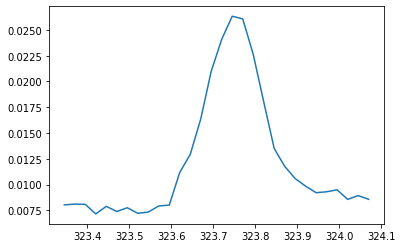

323.745

In [2676]:
exp.Align('rot')
lens_center_x = StripFindCenter(.75,0.025,0)
display(lens_center_x)

In [2354]:
peaks, _ = signal.find_peaks(np.array(maxes)*-1, prominence=.002)
widths = signal.peak_widths(np.array(maxes)*-1, peaks)
lens_center_x = lens_positions[int(widths[3][1])]
lens_center_x

IndexError: index 1 is out of bounds for axis 0 with size 0

323.72

In [2677]:
exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())


In [2564]:
#exp.RotateLens(5)
exp.SwitchMotor('rot')


Manually connect rot motor and disconnect rot motor


#### Rotation test

In [2386]:
## Move LED up and change motor to LED
led_displacement_y = 1.
exp.led_motor.MoveMotor(lens_center - exp.led_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(led_displacement_y) #Moving LED 2mm up to take substrate data 
exp.SwitchMotor('rot')


Manually connect rot motor and disconnect led motor


In [2537]:
exp.Align('sipm')
exp.rot_motor.MoveMotor(pos - exp.rot_motor.GetCurrentPosition())

exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
lens_offset = 4.
exp.lens_motor.MoveMotor(lens_offset)
rots = 30
exp.RotateLens(rots)

display(FirstOrderDisplacement_oblique(lens_offset,rots))
disp = FirstOrderDisplacement_oblique(lens_offset,rots)
exp.sipm_motor.MoveMotor(disp)


75.526699912218

In [2541]:
display(FirstOrderDisplacement_oblique(4.,30))
exp.rot_motor.MoveMotor(pos - exp.rot_motor.GetCurrentPosition())


75.526699912218

'15/15'

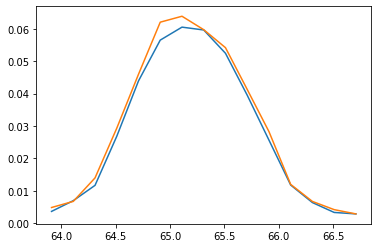

In [2341]:
sipm_dx = 0.2
sipm_scan_width = 3. # mm
sipm_num_measurements = int(sipm_scan_width / sipm_dx)

###Substrate data
exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
exp.Align('sipm')

position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=True)
exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
 

###Air data
exp.Align('sipm')

exp.lens_motor.MoveMotor(40.)
position_led_air, positions_sipm_air, maxes_air = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=True)
exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())


plt.plot(positions_sipm,maxes)
plt.plot(positions_sipm_air,maxes_air)

plt.show()

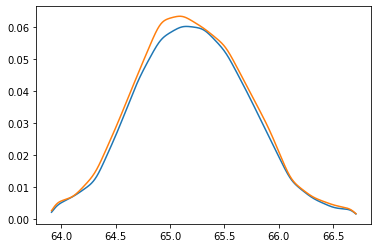

-0.058858858858855

-9.807503383756083

In [2342]:
from scipy import interpolate
thickness = 0.5
index = 1.457
FWHM = 0.1

meio = (positions_sipm[len(positions_sipm)-1]+positions_sipm[0])/2
x = np.linspace(positions_sipm[0], positions_sipm[len(positions_sipm)-1], 1000)
sigma=FWHM/2.3548
G = np.exp(-(x-meio)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))
G = G/sum(G)

interp = interpolate.interp1d(positions_sipm, maxes, kind = "linear")
maxes3 = interp(x)
maxes3 = np.convolve(maxes3, G, mode='same')

interp = interpolate.interp1d(positions_sipm, maxes_air, kind = "linear")
maxes_air2 = interp(x)
maxes_air2 = np.convolve(maxes_air2, G, mode='same')

plt.plot(x,maxes3)
plt.plot(x,maxes_air2)
plt.show()

indices = signal.find_peaks(np.array(maxes3), prominence=0.01)[0]
substrate_center =x[int(indices)]
indices = signal.find_peaks(np.array(maxes_air2), prominence=0.01)[0]
air_center =x[int(indices)]
dbeam = air_center-substrate_center
thetain = np.arctan(dbeam/thickness)
display(dbeam)
thetaI = np.arcsin(index*np.sin(thetain))
display(thetaI*180/np.pi)

In [2340]:
exp.RotateLens(thetaI*180/np.pi)

#### Test split lens orientation

In [2343]:
exp.SwitchMotor('led')

Manually connect led motor and disconnect rot motor


In [2314]:
led_scan_width = 5.
dx_led = .1
num_led_steps = int(led_scan_width / dx_led)
lens_offset = .1 # mm
lens_scan_width = 2.
dx_lens = .5
num_lens_steps = int(lens_scan_width / dx_lens)
maxes = []
lens_positions = []
led_positions = []

exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(lens_center - exp.led_motor.GetCurrentPosition())
exp.lens_motor.MoveMotor(-lens_offset)
for lens_step in range(num_lens_steps):
    exp.led_motor.MoveMotor(-led_scan_width/2.)
    lens_positions.append(exp.lens_motor.GetCurrentPosition())
    for step in range(num_led_steps):
        clear_output(wait=True)
        display('Scan 1/3: '+str(step+1)+"/"+str(num_led_steps))
        maxes_l.append(osc.MeasurePeaktoPeak(scope, 15))
        led_positions_l.append(exp.led_motor.GetCurrentPosition())
        exp.led_motor.MoveMotor(dx_led)
    exp.led_motor.MoveMotor(-led_scan_width/2.)

'Scan 1/3: 47/50'

KeyboardInterrupt: 

In [2373]:
exp.Align('sipm')
led_scan_width = 1.5
dx_led = .1
num_led_steps = int(led_scan_width / dx_led)
lens_offset = 4. # mm
maxes_l = []
led_positions_l = []
maxes_c = []
led_positions_c = []
maxes_r = []
led_positions_r = []
correction = 0.
exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(lens_center - exp.led_motor.GetCurrentPosition())
exp.lens_motor.MoveMotor(-lens_offset)
exp.led_motor.MoveMotor(-led_scan_width/2.)
exp.led_motor.MoveMotor(-correction*lens_offset)
lens_pos_l = exp.lens_motor.GetCurrentPosition()
for step in range(num_led_steps):
    clear_output(wait=True)
    display('Scan 1/3: '+str(step+1)+"/"+str(num_led_steps))
    maxes_l.append(osc.MeasurePeaktoPeak(scope, 15))
    led_positions_l.append(exp.led_motor.GetCurrentPosition())
    exp.led_motor.MoveMotor(dx_led)
exp.led_motor.MoveMotor(-led_scan_width/2.)

exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(lens_center - exp.led_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(-led_scan_width/2.)
lens_pos_c = exp.lens_motor.GetCurrentPosition()
for step in range(num_led_steps):
    clear_output(wait=True)
    display('Scan 2/3: '+str(step+1)+"/"+str(num_led_steps))
    maxes_c.append(osc.MeasurePeaktoPeak(scope, 15))
    led_positions_c.append(exp.led_motor.GetCurrentPosition())
    exp.led_motor.MoveMotor(dx_led)
exp.led_motor.MoveMotor(-led_scan_width/2.)

exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(lens_center - exp.led_motor.GetCurrentPosition())
exp.lens_motor.MoveMotor(lens_offset)
exp.led_motor.MoveMotor(correction*lens_offset)

exp.led_motor.MoveMotor(-led_scan_width/2.)
lens_pos_r = exp.lens_motor.GetCurrentPosition()
for step in range(num_led_steps):
    clear_output(wait=True)
    display('Scan 3/3: '+str(step+1)+"/"+str(num_led_steps))
    maxes_r.append(osc.MeasurePeaktoPeak(scope, 15))
    led_positions_r.append(exp.led_motor.GetCurrentPosition())
    exp.led_motor.MoveMotor(dx_led)
exp.led_motor.MoveMotor(-led_scan_width/2.)

'Scan 3/3: 15/15'

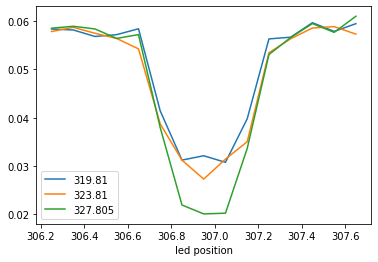

In [2374]:
plt.plot(led_positions_l, maxes_l, label=str(lens_pos_l))
plt.plot(led_positions_l, maxes_c, label=str(lens_pos_c))
plt.plot(led_positions_l, maxes_r, label=str(lens_pos_r))
plt.xlabel('led position')
plt.legend()
plt.show()

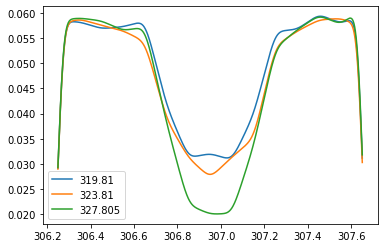

-0.046246246246255396

-0.07707707707709233

0.03083083083083693

-0.023123123123127698

-0.3312106516594931

In [2375]:
from scipy import interpolate

FWHM = 0.05
sigma=FWHM/2.3548

meio = (led_positions_l[len(led_positions_l)-1]+led_positions_l[0])/2
xl = np.linspace(led_positions_l[0], led_positions_l[len(led_positions_l)-1], 1000)
G = np.exp(-(xl-meio)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))
G = G/sum(G)

xl = np.linspace(led_positions_l[0], led_positions_l[len(led_positions_l)-1], 1000)
interp = interpolate.interp1d(led_positions_l, maxes_l, kind = "linear")
maxes3l = interp(xl)
maxes3l = np.convolve(maxes3l, G, mode='same')

xc = np.linspace(led_positions_c[0], led_positions_c[len(led_positions_c)-1], 1000)
interp = interpolate.interp1d(led_positions_c, maxes_c, kind = "linear")
maxes3c = interp(xc)
maxes3c = np.convolve(maxes3c, G, mode='same')

xr = np.linspace(led_positions_r[0], led_positions_r[len(led_positions_r)-1], 1000)
interp = interpolate.interp1d(led_positions_r, maxes_r, kind = "linear")
maxes3r = interp(xr)
maxes3r = np.convolve(maxes3r, G, mode='same')

plt.plot(xc,maxes3l, label=str(lens_pos_l))
plt.plot(xc,maxes3c, label=str(lens_pos_c))
plt.plot(xc,maxes3r, label=str(lens_pos_r))
plt.legend()
plt.show()

indices = signal.find_peaks(np.array(maxes3r)*-1, prominence=0.005)[0]
peakr =xr[int(indices[0])]
indices = signal.find_peaks(np.array(maxes3c)*-1, prominence=0.005)[0]
peakc =xc[int(indices[0])]
indices = signal.find_peaks(np.array(maxes3l)*-1, prominence=0.005)[0]
peakl =xl[int(indices[0])]

display(peakr-peakl)
display(peakc-peakl)
display(peakr-peakc)

correction2 = (peakr-peakl)/(lens_offset*2)
display(correction2*lens_offset)

display(np.arctan(correction2)*180/np.pi)

### Test runs

'100/100'

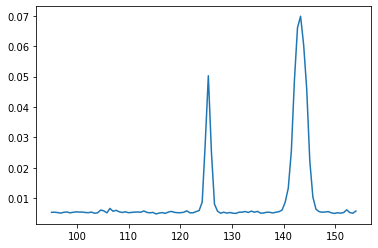

In [333]:
exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(lens_center - exp.led_motor.GetCurrentPosition())
exp.lens_motor.MoveMotor(1)
position_led, positions_sipm, maxes = exp.ScanMaxes(width=60., num_measurements=100)
plt.plot(positions_sipm, maxes)

# Strip Metalens Runs

In [1376]:
def FirstOrderDisplacement(lens_offset):
    sipm_lens_distance = 12.5
    focal_length = 0.7
    return (- sipm_lens_distance / focal_length + 1.) * lens_offset

In [2638]:
def FirstOrderDisplacement_oblique(lens_offset,angle):
    sipm_lens_distance = 125 ## mm
    focal_length = 7. ##mm
    angle = angle*np.pi/180.
    theta = (-lens_offset / np.sqrt(lens_offset**2+focal_length**2)+np.sin(angle))
    if abs(theta)>=1.:
        return np.nan
    else:
        theta = np.arcsin(theta)
        return sipm_lens_distance*np.tan(theta-angle)+lens_offset

In [2642]:
lens_offset = 1.
display(FirstOrderDisplacement_oblique(lens_offset,10.))
FirstOrderDisplacement(lens_offset)

-16.9086086153626

-16.857142857142858

In [2346]:
correction

0.0

In [2362]:
# Run as of 5/27/2022
start_time = time.time()
lens_scan_width = 8.
lens_dx = .2
lens_num_measurements = int( lens_scan_width / lens_dx)
sipm_dx = 0.2
base_file_name = '_stripmetalens_50ns_15sweeps.csv'
run_num = 1752
current_rot = 0.0


exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(lens_center - exp.led_motor.GetCurrentPosition())

exp.lens_motor.MoveMotor(-lens_scan_width/2.)
exp.led_motor.MoveMotor(correction*(-lens_scan_width/2.))

for lens_scan in range(lens_num_measurements):

    exp.Align('sipm')
    position_lens = exp.lens_motor.GetCurrentPosition()
       
    if abs(position_lens - lens_center_x) <= 1.0:
        sipm_scan_width = 60. # mm
        sipm_num_measurements = int(sipm_scan_width / sipm_dx)
        position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=True)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, current_rot)
    
    else:
        sipm_scan_width = 30. # mm
        sipm_num_measurements = int(sipm_scan_width / sipm_dx)
        position_led1, positions_sipm1, maxes1 = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=True)
    
        first_order_pos = FirstOrderDisplacement(lens_center_x - exp.lens_motor.GetCurrentPosition())
        exp.sipm_motor.MoveMotor(first_order_pos)
        sipm_scan_width = 30. # mm
        sipm_num_measurements = int(sipm_scan_width / sipm_dx)
        position_led2, positions_sipm2, maxes2 = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=True)
        
        position_led =  [position_led1 , position_led2]
        positions_sipm = positions_sipm1 + positions_sipm2
        maxes = maxes1+maxes2
        file_name = 'run'+str(run_num)+base_file_name       
        SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, current_rot)
    
    exp.lens_motor.MoveMotor(lens_dx)
    exp.led_motor.MoveMotor(correction*lens_dx)

    run_num += 1
    #print(rot, lens_scan, current_rot)

exp.lens_motor.MoveMotor(-lens_scan_width/2.)
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

'150/150'

Total run time = 190.7563063542048


In [2367]:
# Run as of 06/06/2022
# Substrate only
start_time = time.time()
lens_scan_width = 6.
lens_dx = 1.2
lens_num_measurements = int( lens_scan_width / lens_dx)
sipm_dx = 0.2
base_file_name = '_substratestrip_50ns_15sweeps.csv'
run_num = 1792
current_rot = 0.0
led_displacement_y = 1.

exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(lens_center - exp.led_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(led_displacement_y) #Moving LED 2mm up to take substrate data 
exp.lens_motor.MoveMotor(-lens_scan_width/2.)
for lens_scan in range(lens_num_measurements):
    exp.Align('sipm')
    position_lens = exp.lens_motor.GetCurrentPosition()
    sipm_scan_width = 10. # mm
    sipm_num_measurements = int(sipm_scan_width / sipm_dx)
    position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=True)
    file_name = 'run'+str(run_num)+base_file_name
    SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, current_rot)   
    exp.lens_motor.MoveMotor(lens_dx)
    run_num += 1
    exp.led_motor.MoveMotor(.2)

    #print(rot, lens_scan, current_rot)

exp.lens_motor.MoveMotor(-lens_scan_width/2.)
exp.led_motor.MoveMotor(lens_center - exp.led_motor.GetCurrentPosition())
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

'50/50'

Total run time = 3.8222626566886904


In [2368]:
# Run as of 06/06/2022
# Air only
start_time = time.time()
lens_scan_width = 15.
lens_dx = 15.
lens_num_measurements = int( lens_scan_width / lens_dx)
sipm_dx = 0.2
base_file_name = '_air_50ns_15sweeps.csv'
run_num = 1798
current_rot = 0.0
led_displacement_y = 0.

exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(lens_center - exp.led_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(led_displacement_y) #Moving LED 2mm up to take substrate data 
exp.lens_motor.MoveMotor(-lens_scan_width)
for lens_scan in range(lens_num_measurements):
    exp.Align('sipm')
    position_lens = exp.lens_motor.GetCurrentPosition()
    sipm_scan_width = 10. # mm
    sipm_num_measurements = int(sipm_scan_width / sipm_dx)
    position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=True)
    file_name = 'run'+str(run_num)+base_file_name
    SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, current_rot)
    
   
    
    exp.lens_motor.MoveMotor(lens_dx)
    run_num += 1
    #print(rot, lens_scan, current_rot)

exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(-led_displacement_y)
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

'50/50'

Total run time = 0.8616413354873658


'150/150'

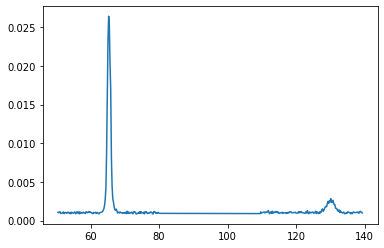

Total run time = 153.42918025652568


In [2687]:
# Run as of 6/7/2022 angle
start_time = time.time()
lens_scan_width = 8.
lens_dx = .25
lens_num_measurements = int( lens_scan_width / lens_dx)
sipm_dx = 0.2
base_file_name = '_stripmetalens_20deg_50ns_15sweeps.csv'
run_num = 1829
current_rot = 20.
exp.Align('rot')
exp.Align('sipm')



exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
exp.RotateLens(current_rot)

exp.lens_motor.MoveMotor(-lens_scan_width/2.)
for lens_scan in range(lens_num_measurements):

    exp.Align('sipm')
    position_lens = exp.lens_motor.GetCurrentPosition()
    display(position_lens - lens_center_x)
    if abs(position_lens - lens_center_x) <= 1.0:
        sipm_scan_width = 60. # mm
        sipm_num_measurements = int(sipm_scan_width / sipm_dx)
        position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=True)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, current_rot)
    
    else:
        sipm_scan_width = 30. # mm
        sipm_num_measurements = int(sipm_scan_width / sipm_dx)
        position_led1, positions_sipm1, maxes1 = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=True)
        display(lens_center_x - exp.lens_motor.GetCurrentPosition())
        first_order_pos = FirstOrderDisplacement_oblique( lens_center_x-exp.lens_motor.GetCurrentPosition(),-current_rot)
        display(first_order_pos)
        exp.sipm_motor.MoveMotor(first_order_pos)
        sipm_scan_width = 30. # mm
        sipm_num_measurements = int(sipm_scan_width / sipm_dx)
        position_led2, positions_sipm2, maxes2 = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=True)
        
        position_led =  [position_led1 , position_led2]
        positions_sipm = positions_sipm1 + positions_sipm2
        maxes = maxes1+maxes2
        file_name = 'run'+str(run_num)+base_file_name       
        SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, current_rot)
    
    exp.lens_motor.MoveMotor(lens_dx)
    run_num += 1
    #print(rot, lens_scan, current_rot)
    plt.plot(positions_sipm,maxes)
    plt.show()
exp.RotateLens(-current_rot)
exp.lens_motor.MoveMotor(-lens_scan_width/2.)
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

In [334]:
lens_center_x

276.0

In [ ]:
a 

In [340]:
a = np.array([1,2, 3])
b = np.array([4,5,6])
c = np.concatenate((a,b))
c

array([1, 2, 3, 4, 5, 6])

In [319]:
lens_center

266.19

In [320]:
lens_center_x

276.0

In [329]:
exp.lens_motor.MoveMotor(40)

In [74]:
# Run with just substrate
start_time = time.time()
num_rots = 100
drot = 1.8
sipm_scan_width = 15
sipm_num_measurements = 50
base_file_name = '_substrate_100ns_15sweeps.csv'
run_num = 756

exp.Align('rot')
current_rot = -drot*num_rots/2
exp.RotateLens(current_rot)
for rot in range(num_rots):
    
    exp.Align('sipm')
    exp.lens_motor.MoveMotor(center - exp.lens_motor.GetCurrentPosition())
    position_lens = exp.lens_motor.GetCurrentPosition()
    position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=False)
    file_name = 'run'+str(run_num)+base_file_name
    SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, current_rot)
    run_num += 1 

    exp.Align('sipm')
    exp.lens_motor.MoveMotor(center - 2 - exp.lens_motor.GetCurrentPosition())
    position_lens = exp.lens_motor.GetCurrentPosition()
    position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=False)
    file_name = 'run'+str(run_num)+base_file_name
    SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, current_rot)
    run_num += 1

    exp.Align('sipm')
    exp.lens_motor.MoveMotor(center + 2 - exp.lens_motor.GetCurrentPosition())
    position_lens = exp.lens_motor.GetCurrentPosition()
    position_led, positions_sipm, maxes = exp.ScanMaxes(width=sipm_scan_width, num_measurements=sipm_num_measurements, print_progress=False)
    file_name = 'run'+str(run_num)+base_file_name
    SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, current_rot)
    run_num += 1
    
    exp.RotateLens(drot)  
    current_rot += drot

exp.Align('rot')
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

Total run time = 331.5511262933413


'50/50'

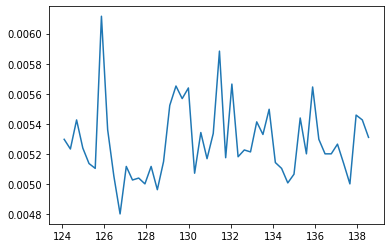

In [20]:
# Testing the new laser (5/13)
position_led, positions_sipm, maxes = exp.ScanMaxes(width=15., num_measurements=50)
plt.plot(positions_sipm, maxes)

In [21]:
exp.lens_motor.MoveMotor(40)

In [24]:
exp.sipm_motor.MoveMotor(2)

In [14]:
print(exp.lens_motor.GetCurrentPosition())
exp.lens_motor.MoveMotor(10)
print(exp.lens_motor.GetCurrentPosition())
exp.lens_motor.MoveMotor(-10)
print(exp.lens_motor.GetCurrentPosition())

483.915
493.91
483.91


In [34]:
print(exp.lens_motor.GetCurrentNumSteps())
exp.lens_motor.MoveSteps(10)
print(exp.lens_motor.GetCurrentNumSteps())
exp.lens_motor.MoveSteps(-10)
print(exp.lens_motor.GetCurrentNumSteps())

90784
90794
90784


In [40]:
print(exp.lens_motor.GetCurrentPosition())
exp.lens_motor.MoveSteps(2000)
print(exp.lens_motor.GetCurrentPosition())
exp.lens_motor.MoveSteps(-2000)
print(exp.lens_motor.GetCurrentPosition())

473.915
483.915
473.915


In [41]:
print(exp.lens_motor.GetCurrentNumSteps())
exp.lens_motor.MoveMotor(10)
print(exp.lens_motor.GetCurrentNumSteps())
exp.lens_motor.MoveMotor(-10)
print(exp.lens_motor.GetCurrentNumSteps())

94783
96782
94782


In [15]:
print(exp.sipm_motor.GetCurrentPosition())
exp.sipm_motor.MoveMotor(10)
print(exp.sipm_motor.GetCurrentPosition())
exp.sipm_motor.MoveMotor(-10)
print(exp.sipm_motor.GetCurrentPosition())

157.225
167.22
157.22


In [24]:
dx_per_step = 0.005
distance = 10.0
sign = distance / abs(distance)
num_steps = int(abs(distance) // dx_per_step)

In [38]:
10/.005

2000.0

In [32]:
dx_lens = 10.0 / 10.
num_steps = int(abs(dx_lens) // dx_per_step)

In [33]:
exp.

199

In [22]:
exp.Align()

LED motor is off. Switch motors to align


In [145]:
exp.sipm_motor.MoveMotor(80)
exp.lens_motor.MoveMotor(-60)
exp.led_motor.MoveMotor(10)
exp.led_motor.MoveMotor(-10)

In [146]:
exp.led_motor.MoveMotor(-10)
exp.led_motor.MoveMotor(10)

In [144]:
exp.lens_motor.MoveMotor(60)

In [150]:
exp.SwitchMotor('rot')

Manually connect rot motor and disconnect led motor


In [324]:
exp.Align('lens')

In [141]:
exp.Rot

LED motor is off. Switch motors to align


In [142]:
exp.RotateLens(-20)

'180/180'

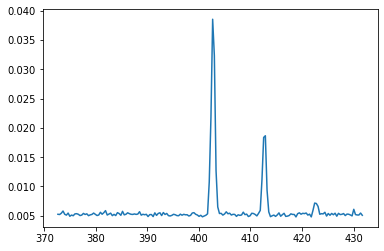

In [56]:
# Measure voltage at each distance
width = 60
num_measurements = 180
num_sweeps = 10
distance_to_move = width/num_measurements
maxes = []
positions_sipm = []
position_led = led_motor.GetCurrentPosition()
sipm_motor.MoveMotor(-width/2.)
for i in range(num_measurements):
    clear_output(wait=True)
    display(str(i+1)+"/"+str(num_measurements))
    sipm_motor.MoveMotor(distance_to_move)
    maxes.append(osc.MeasurePeaktoPeak(scope, num_sweeps))
    positions_sipm.append(sipm_motor.GetCurrentPosition())
sipm_motor.MoveMotor(-width/2.)
plt.plot(positions_sipm, maxes)

# Linearity Run
This run takes data to find the linearity of the SiPM at a given LED width for different LED voltages. 

In [143]:
exp.lens_motor.MoveMotor(-40)

In [162]:
values = []
num_voltages = 59
step_size = 0.1
start_voltage = 0.1
end_voltage = 6.0  
voltage_range = np.arange(start_voltage, end_voltage,step_size)
for i in range(num_voltages):
    scope.timeout = 5000
    scope.clear()
    r = scope.query(r"""vbs? 'return=app.WaitUntilIdle(5)' """)
    values.append(osc.MeasurePeaktoPeak(scope, 50)) #- dark_count
    
    clear_output(wait=True)
    display('Turn Knob to '+str(start_voltage+(1+i)*step_size)+ 'V')
    time.sleep(2)

'Turn Knob to 6.0V'

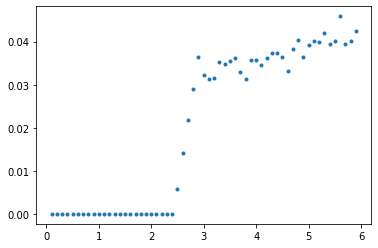

In [163]:
plt.plot(voltage_range, values,  '.') # sipm slit closed most of the way

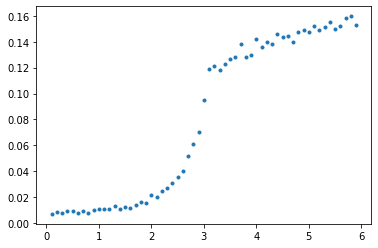

In [160]:
plt.plot(voltage_range, values,  '.') # sipm slit all the way open, lens out of the way (saved)

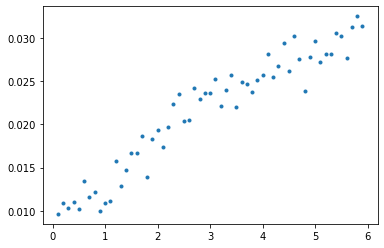

In [147]:
plt.plot(voltage_range, values[0:59],  '.') # lens out of the way

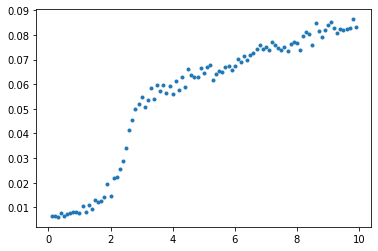

In [140]:
plt.plot(voltage_range, values,  '.') # lens in the way and tilted (saved)

In [161]:
file_name = 'linearity_100ns_0.1_6V.csv'
with open(file_name, mode='w') as file:
    writer = csv.writer(file)
    
    writer.writerow(values)

### Saving Data

In [20]:
file_name = 'run03_metalens_100ns_10sweeps.csv'
def SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes, rot_angle):
    with open('data/'+file_name, mode='w') as file:
                writer = csv.writer(file)
                
                writer.writerow(['position_lens'])
                writer.writerow([position_lens]) 
                writer.writerow(['position_led'])
                writer.writerow([position_led])
                writer.writerow(['positions_sipm'])
                writer.writerow(positions_sipm)
                writer.writerow(['maxes'])
                writer.writerow(maxes)
                writer.writerow(['rotation'])
                writer.writerow([rot_angle])

# Close after done running

In [ ]:
# Make sure to close the connection (in teh reverse order of setting it up)
scope.close()
rm.close()